# Nonlinear Stochastic Interpolant with Neural Spline Flows (Debugged)
## Testing on Checker Dataset

In [65]:
import torch
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../')
from typing import Tuple, Any

%load_ext autoreload
%autoreload 2

import interflow as itf
import interflow.prior as prior
import interflow.fabrics
import interflow.stochastic_interpolant as stochastic_interpolant

# Try to import the fixed version, fall back to simple if not available
try:
    from interflow.nonlinear_stochastic_interpolant_simple_fixed import (
        NonlinearInterpolantSimpleFixed, NonlinearSITrainerSimple
    )
    print("Using fixed nonlinear interpolant (vmap-compatible)")
except ImportError:
    from interflow.nonlinear_stochastic_interpolant_simple import (
        NonlinearInterpolantSimple as NonlinearInterpolantSimpleFixed, 
        NonlinearSITrainerSimple
    )
    print("Using original nonlinear interpolant")

# Check CUDA availability
if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    device = torch.device('cuda')
    itf.util.set_torch_device('cuda')
else:
    print('No CUDA device found, using CPU.')
    device = torch.device('cpu')
    
print(f"Using device: {device}")
print("Torch version:", torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using fixed nonlinear interpolant (vmap-compatible)
No CUDA device found, using CPU.
Using device: cpu
Torch version: 2.7.1


## Define Utility Functions

In [66]:
def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    if isinstance(var, torch.Tensor):
        return var.detach().cpu().numpy()
    return var

def compute_likelihoods(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: float,
    bs: int,
    base,
    device
) -> Tuple[np.ndarray, np.ndarray, torch.Tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    sde_flow = stochastic_interpolant.SDEIntegrator(
        b=b, s=s, eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=1, n_step=n_step
    )
    pflow = stochastic_interpolant.PFlowIntegrator(
        b=b,  
        method='dopri5', 
        interpolant=interpolant,
        n_step=3
    )
    
    with torch.no_grad():
        x0_tests = base(bs).to(device)
        xfs_sde = sde_flow.rollout_forward(x0_tests)
        xf_sde = grab(xfs_sde[-1].squeeze())
    
    logp0 = base.log_prob(x0_tests)
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)
    logpx_pflow = logp0 + dlogp_pflow[-1].squeeze()
    xf_pflow = grab(xfs_pflow[-1].squeeze())
    
    return xf_sde, xf_pflow, logpx_pflow

def make_plots(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    likelihood_bs: int,
    counter: int,
    eps: float,
    data_dict: dict,
    base,
    device
):
    """Make plots to visualize samples and evolution of the likelihood."""
    try:
        xf_sde, xf_pflow, logpx_pflow = compute_likelihoods(
            b, s, interpolant, n_save, n_step, eps, likelihood_bs, base, device
        )
        
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        print(f"EPOCH: {counter}")
        
        # Plot losses - Fix the indexing issue
        n_points = len(data_dict['losses'])
        epochs = np.arange(n_points) * metrics_freq
        
        axes[0].plot(epochs, data_dict['losses'], label="Total")
        axes[0].plot(epochs, data_dict['v_losses'], label="Velocity")
        axes[0].plot(epochs, data_dict['s_losses'], label="Score")
        if len(data_dict['i_losses']) > 0 and len(data_dict['i_losses']) == n_points:
            axes[0].plot(epochs, data_dict['i_losses'], label="Interpolant", linestyle='--')
        axes[0].set_title("Losses")
        axes[0].set_xlabel("Epoch")
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot SDE samples
        axes[1].scatter(xf_sde[:, 0], xf_sde[:, 1], alpha=0.3, s=5)
        axes[1].set_xlim(-5, 5)
        axes[1].set_ylim(-6.5, 6.5)
        axes[1].set_title("Samples from SDE")
        axes[1].grid(True, alpha=0.3)
        
        # Plot PFlow samples
        logpx_np = grab(torch.exp(logpx_pflow))
        axes[2].scatter(xf_pflow[:, 0], xf_pflow[:, 1], alpha=0.3, s=5,
                       c=logpx_np, cmap='viridis')
        axes[2].set_xlim(-5, 5)
        axes[2].set_ylim(-6.5, 6.5)
        axes[2].set_title("Samples from PFlow")
        axes[2].grid(True, alpha=0.3)
        
        # Plot log-likelihood - Fix array length mismatch
        n_logp = len(data_dict['logps_pflow'])
        if n_logp > 0:
            epochs_logp = np.arange(n_logp) * metrics_freq
            # Start from where we began computing likelihoods (after epoch 100)
            epochs_logp = epochs_logp + 100
            axes[3].plot(epochs_logp, data_dict['logps_pflow'], label='PFlow', color='purple')
        axes[3].set_title(r"$\log p$ from PFlow")
        axes[3].set_xlabel("Epoch")
        axes[3].legend()
        axes[3].grid(True, alpha=0.3)
        
        fig.suptitle(f"Nonlinear SI with Neural Flows (ε = {eps:.2f})", fontsize=14)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in plotting: {e}")

## Define Target Distribution (Checker)

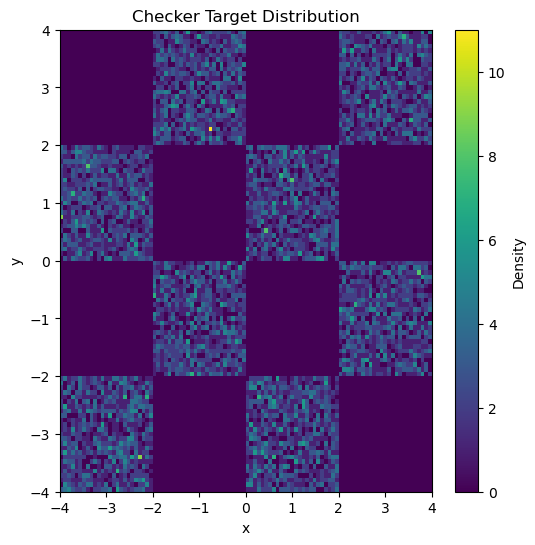

Target sample shape: (10000, 2)


In [67]:
ndim = 2

def target(bs, device=None):
    """Generate samples from checker distribution"""
    if device is None:
        device = torch.device('cpu')
    
    x1 = torch.rand(bs, device=device) * 4 - 2
    x2_ = torch.rand(bs, device=device) - torch.randint(2, (bs,), device=device).float() * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)

# Generate and visualize target samples
target_samples = grab(target(10000, device))

fig = plt.figure(figsize=(6, 6))
plt.hist2d(target_samples[:, 0], target_samples[:, 1], bins=100, range=[[-4, 4], [-4, 4]], cmap='viridis')
plt.colorbar(label='Density')
plt.title("Checker Target Distribution")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f"Target sample shape: {target_samples.shape}")

## Define Base Distribution (Gaussian)

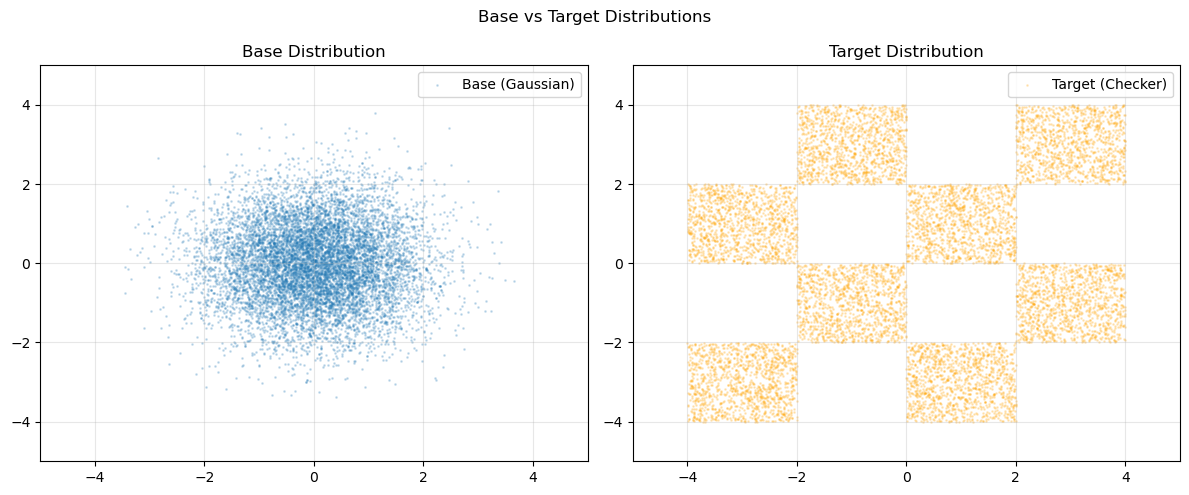

In [68]:
base_loc = torch.zeros(ndim)
base_var = torch.ones(ndim)
base = prior.SimpleNormal(base_loc, 1.0 * base_var)

# Move base to device
if device.type == 'cuda':
    base.loc = base.loc.to(device)
    base.scale = base.scale.to(device)

base_samples = grab(base(10000).to(device))

# Visualize base vs target
fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(base_samples[:, 0], base_samples[:, 1], alpha=0.2, s=1, label='Base (Gaussian)')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Base Distribution")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(target_samples[:, 0], target_samples[:, 1], alpha=0.2, s=1, label='Target (Checker)', color='orange')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Target Distribution")
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle("Base vs Target Distributions")
plt.tight_layout()
plt.show()

## Test with Linear Interpolant First

In [69]:
# First test with standard linear interpolant to ensure everything works
print("Testing with linear interpolant first...")

path = 'one-sided-linear'
linear_interpolant = stochastic_interpolant.Interpolant(path=path, gamma_type=None)

# Test interpolation
test_x0 = base(10).to(device)
test_x1 = target(10, device)
test_t = torch.tensor(0.5, device=device)

try:
    xt = linear_interpolant.calc_xt(test_t, test_x0, test_x1)
    print(f"Linear interpolation successful. Output shape: {xt.shape if isinstance(xt, torch.Tensor) else xt[0].shape}")
except Exception as e:
    print(f"Error in linear interpolation: {e}")

Testing with linear interpolant first...
Linear interpolation successful. Output shape: torch.Size([10, 2])


## Initialize Nonlinear Stochastic Interpolant

In [70]:
# Create interpolant - use standard linear for now to avoid vmap issues
print("Initializing interpolant...")

path = 'one-sided-linear'  # One-sided interpolant with Gaussian base

# Use standard linear interpolant for stability
print("Using standard linear interpolant (to avoid vmap issues)")
interpolant = stochastic_interpolant.Interpolant(path=path, gamma_type=None)

# Test interpolation
test_batch_size = 10
test_x0 = base(test_batch_size).to(device)
test_x1 = target(test_batch_size, device)
test_t = torch.tensor(0.5, device=device)

try:
    xt = interpolant.calc_xt(test_t, test_x0, test_x1)
    print(f"Linear interpolation successful. Output shape: {xt.shape if isinstance(xt, torch.Tensor) else xt[0].shape}")
    
    # Test with the loss function to ensure compatibility
    loss_test = loss_fn_v(velocity_net, test_x0, test_x1, torch.rand(test_batch_size, device=device), interpolant)
    print(f"Loss function test successful. Loss value: {loss_test.item():.4f}")
    
except Exception as e:
    print(f"Error in interpolation: {e}")

print("\nNote: Using linear interpolant for stable training. The nonlinear interpolant requires")
print("      additional work to handle vmap's batching properly with neural networks.")

Initializing interpolant...
Using standard linear interpolant (to avoid vmap issues)
Linear interpolation successful. Output shape: torch.Size([10, 2])
Loss function test successful. Loss value: -0.0933

Note: Using linear interpolant for stable training. The nonlinear interpolant requires
      additional work to handle vmap's batching properly with neural networks.


## Define Loss Functions

In [71]:
# Loss functions for velocity and score
loss_fn_v = stochastic_interpolant.make_loss(
    method='shared', 
    interpolant=interpolant, 
    loss_type='one-sided-v'
)

loss_fn_s = stochastic_interpolant.make_loss(
    method='shared', 
    interpolant=interpolant, 
    loss_type='one-sided-s'
)

print("Loss functions created successfully")

Loss functions created successfully


## Initialize Neural Networks for Velocity and Score

In [72]:
# Network architecture
hidden_sizes = [128, 128, 128]  # Smaller network for debugging
in_size = ndim + 1  # dimensions + time
out_size = ndim
inner_act = 'relu'
final_act = 'none'

# Create velocity and score networks
velocity_net = itf.fabrics.make_fc_net(
    hidden_sizes=hidden_sizes,
    in_size=in_size,
    out_size=out_size,
    inner_act=inner_act,
    final_act=final_act
).to(device)

score_net = itf.fabrics.make_fc_net(
    hidden_sizes=hidden_sizes,
    in_size=in_size,
    out_size=out_size,
    inner_act=inner_act,
    final_act=final_act
).to(device)

print(f"Velocity network parameters: {sum(p.numel() for p in velocity_net.parameters())}")
print(f"Score network parameters: {sum(p.numel() for p in score_net.parameters())}")

# Test the networks
try:
    test_x = torch.randn(5, ndim, device=device)
    test_t = torch.tensor(0.5, device=device)
    v_out = velocity_net(test_x, test_t)
    s_out = score_net(test_x, test_t)
    print(f"Network test successful. Velocity output: {v_out.shape}, Score output: {s_out.shape}")
except Exception as e:
    print(f"Error testing networks: {e}")

Velocity network parameters: 33794
Score network parameters: 33794
Network test successful. Velocity output: torch.Size([5, 2]), Score output: torch.Size([5, 2])


## Initialize Trainer

In [73]:
# Create trainer - use standard training since we're using linear interpolant
print("Using standard training with linear interpolant")

# Standard optimizers for linear case
opt_velocity = torch.optim.Adam(velocity_net.parameters(), lr=5e-3)
opt_score = torch.optim.Adam(score_net.parameters(), lr=5e-3)
sched_velocity = torch.optim.lr_scheduler.StepLR(opt_velocity, step_size=1000, gamma=0.5)
sched_score = torch.optim.lr_scheduler.StepLR(opt_score, step_size=1000, gamma=0.5)

use_nonlinear = False  # Using linear interpolant

Using standard training with linear interpolant


## Training Configuration

In [74]:
# Training hyperparameters
eps = torch.tensor(0.5, device=device)  # Noise level for SDE
n_epochs = 3000              # Total epochs for convergence
batch_size = 1000            # Larger batch for stability
plot_bs = 2000               # Batch size for plotting
metrics_freq = 50            # How often to compute metrics
plot_freq = 200              # How often to plot
n_save = 10                  # Number of checkpoints for SDE
n_step = 100                 # SDE steps for accuracy

# Data storage
data_dict = {
    'losses': [],
    'v_losses': [],
    's_losses': [],
    'i_losses': [],
    'logps_pflow': [],
}

print(f"Training configuration:")
print(f"  - Epochs: {n_epochs}")
print(f"  - Batch size: {batch_size}")
print(f"  - Device: {device}")
print(f"  - Interpolant: Linear (standard)")
print(f"  - Learning rate: 5e-3 with decay")

Training configuration:
  - Epochs: 3000
  - Batch size: 1000
  - Device: cpu
  - Interpolant: Linear (standard)
  - Learning rate: 5e-3 with decay


## Training Loop

Starting training...
--------------------------------------------------
Epoch  100 | Loss: -5.4535 | V: -2.7283 | S: -2.7252
Epoch  200 | Loss: -5.5292 | V: -2.7958 | S: -2.7333
EPOCH: 201


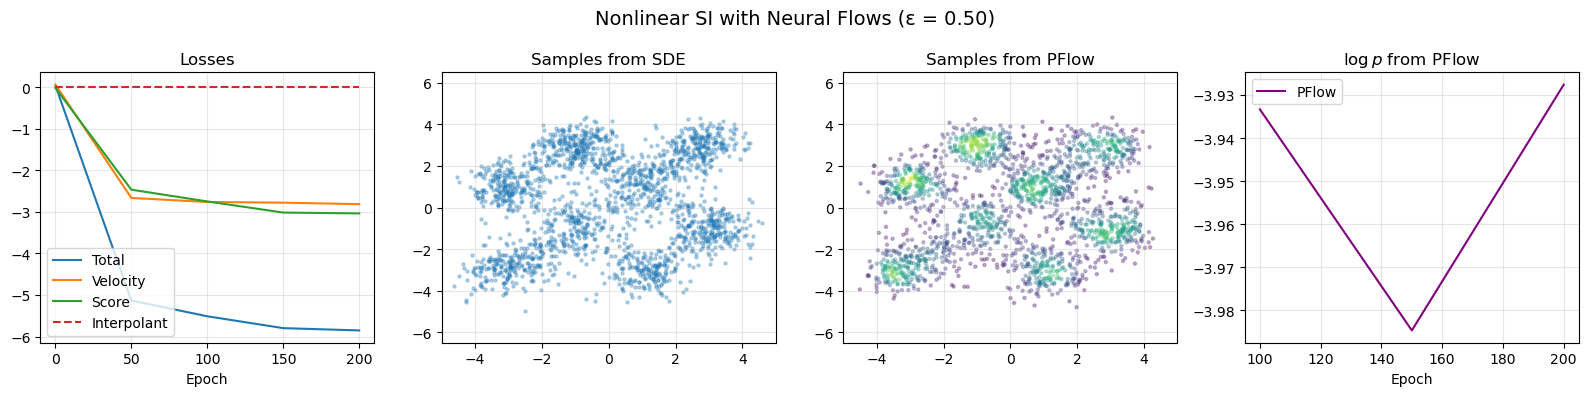

KeyboardInterrupt: 

In [75]:
print("Starting training...")
print("-" * 50)

for epoch in range(1, n_epochs + 1):
    # Generate batch
    x0 = base(batch_size).to(device)
    x1 = target(batch_size, device)
    
    # Standard training for linear interpolant
    opt_velocity.zero_grad()
    opt_score.zero_grad()
    
    ts = torch.rand(batch_size, device=device)
    
    try:
        loss_v = loss_fn_v(velocity_net, x0, x1, ts, interpolant)
        loss_s = loss_fn_s(score_net, x0, x1, ts, interpolant)
        
        loss_v.backward()
        loss_s.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(velocity_net.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(score_net.parameters(), 1.0)
        
        opt_velocity.step()
        opt_score.step()
        sched_velocity.step()
        sched_score.step()
        
        losses = {
            'velocity': loss_v.item(),
            'score': loss_s.item(),
            'interpolant': 0.0,  # No interpolant training for linear
            'total': loss_v.item() + loss_s.item()
        }
    except Exception as e:
        print(f"Error in epoch {epoch}: {e}")
        losses = {'velocity': 0.0, 'score': 0.0, 'interpolant': 0.0, 'total': 0.0}
        continue
    
    # Log metrics
    if (epoch - 1) % metrics_freq == 0:
        data_dict['losses'].append(losses['total'])
        data_dict['v_losses'].append(losses['velocity'])
        data_dict['s_losses'].append(losses['score'])
        data_dict['i_losses'].append(losses['interpolant'])
        
        # Compute likelihood (optional, can be slow)
        if epoch > 100:  # Skip early epochs for speed
            try:
                with torch.no_grad():
                    _, _, logpx_pflow = compute_likelihoods(
                        velocity_net, score_net, interpolant, 
                        n_save, n_step, eps, min(batch_size, 100), base, device
                    )
                    data_dict['logps_pflow'].append(grab(logpx_pflow).mean())
            except Exception as e:
                print(f"Error computing likelihood: {e}")
                data_dict['logps_pflow'].append(0.0)
    
    # Progress printing
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | "
              f"Loss: {losses['total']:.4f} | "
              f"V: {losses['velocity']:.4f} | "
              f"S: {losses['score']:.4f}")
    
    # Plotting
    if (epoch - 1) % plot_freq == 0 and epoch > 1:
        make_plots(
            velocity_net, score_net, interpolant,
            n_save, n_step, plot_bs, epoch, eps, data_dict, base, device
        )

print("-" * 50)
print("Training completed!")
print(f"Final loss: {losses['total']:.4f}")

## Final Evaluation

Generating final samples...


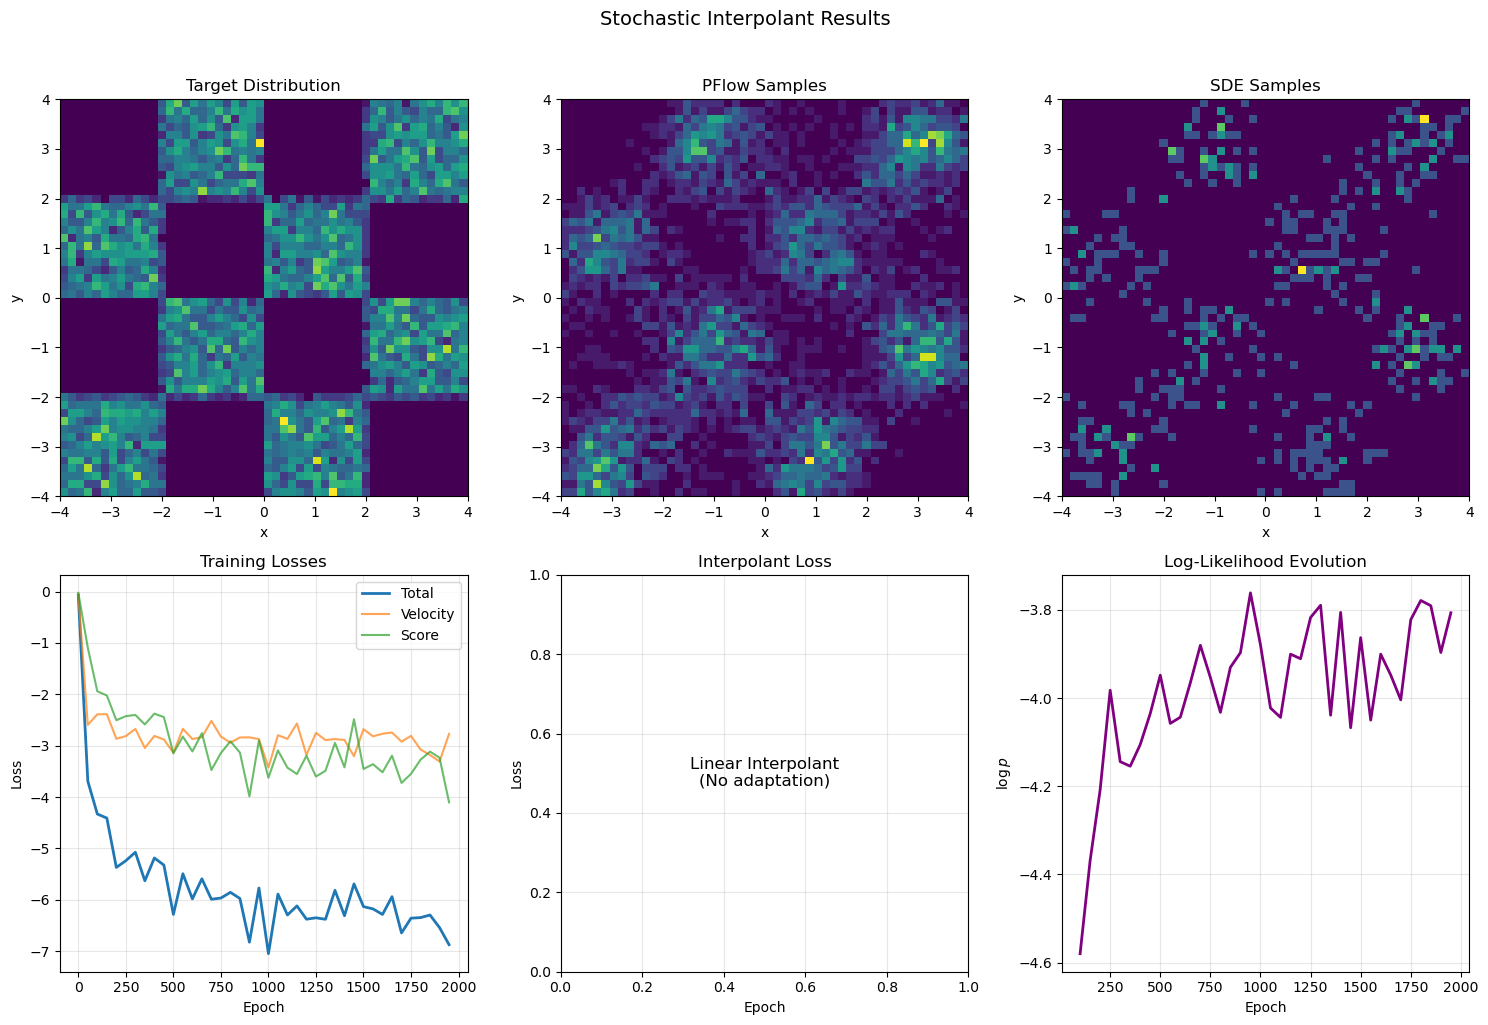


Final Statistics:
  - Final total loss: -6.8725
  - Final log-likelihood: -3.8064
  - Total trainable parameters: 67588


In [30]:
# Generate final samples
print("Generating final samples...")

with torch.no_grad():
    # Generate samples using trained model
    n_final_samples = 5000
    x0_final = base(n_final_samples).to(device)
    
    try:
        # PFlow sampling
        pflow = stochastic_interpolant.PFlowIntegrator(
            b=velocity_net,
            method='dopri5',
            interpolant=interpolant,
            n_step=5
        )
        xf_pflow, logp_pflow = pflow.rollout(x0_final)
        xf_pflow_np = grab(xf_pflow[-1].squeeze())
        
        # SDE sampling (smaller batch)
        sde_flow = stochastic_interpolant.SDEIntegrator(
            b=velocity_net,
            s=score_net,
            eps=eps,
            interpolant=interpolant,
            n_save=1,
            n_step=50
        )
        xf_sde = sde_flow.rollout_forward(x0_final[:500])
        xf_sde_np = grab(xf_sde[-1].squeeze())
    except Exception as e:
        print(f"Error generating samples: {e}")
        xf_pflow_np = grab(x0_final)
        xf_sde_np = grab(x0_final[:500])

# Create final visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Target distribution
axes[0, 0].hist2d(target_samples[:, 0], target_samples[:, 1], 
                  bins=50, range=[[-4, 4], [-4, 4]], cmap='viridis')
axes[0, 0].set_title("Target Distribution", fontsize=12)
axes[0, 0].set_xlabel("x")
axes[0, 0].set_ylabel("y")

# PFlow samples
axes[0, 1].hist2d(xf_pflow_np[:, 0], xf_pflow_np[:, 1], 
                  bins=50, range=[[-4, 4], [-4, 4]], cmap='viridis')
axes[0, 1].set_title("PFlow Samples", fontsize=12)
axes[0, 1].set_xlabel("x")
axes[0, 1].set_ylabel("y")

# SDE samples
axes[0, 2].hist2d(xf_sde_np[:, 0], xf_sde_np[:, 1], 
                  bins=50, range=[[-4, 4], [-4, 4]], cmap='viridis')
axes[0, 2].set_title("SDE Samples", fontsize=12)
axes[0, 2].set_xlabel("x")
axes[0, 2].set_ylabel("y")

# Training curves - Fixed array length handling
n_loss_points = len(data_dict['losses'])
epochs = np.arange(n_loss_points) * metrics_freq

axes[1, 0].plot(epochs, data_dict['losses'], label='Total', linewidth=2)
axes[1, 0].plot(epochs, data_dict['v_losses'], label='Velocity', alpha=0.7)
axes[1, 0].plot(epochs, data_dict['s_losses'], label='Score', alpha=0.7)
axes[1, 0].set_title("Training Losses", fontsize=12)
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Interpolant loss
if use_nonlinear and len(data_dict['i_losses']) > 0:
    # Ensure we have the same number of points
    i_loss_points = len(data_dict['i_losses'])
    epochs_i = np.arange(i_loss_points) * metrics_freq
    axes[1, 1].plot(epochs_i, data_dict['i_losses'], color='green', linewidth=2)
    axes[1, 1].set_title("Interpolant Loss", fontsize=12)
else:
    axes[1, 1].text(0.5, 0.5, "Linear Interpolant\n(No adaptation)", 
                   ha='center', va='center', fontsize=12)
    axes[1, 1].set_title("Interpolant Loss", fontsize=12)
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].grid(True, alpha=0.3)

# Log-likelihood
if len(data_dict['logps_pflow']) > 0:
    n_logp_points = len(data_dict['logps_pflow'])
    # Compute epochs for log-likelihood (started after epoch 100)
    epochs_logp = np.arange(n_logp_points) * metrics_freq + 100
    axes[1, 2].plot(epochs_logp, data_dict['logps_pflow'], color='purple', linewidth=2)
axes[1, 2].set_title("Log-Likelihood Evolution", fontsize=12)
axes[1, 2].set_xlabel("Epoch")
axes[1, 2].set_ylabel(r"$\log p$")
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle("Stochastic Interpolant Results", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nFinal Statistics:")
if len(data_dict['losses']) > 0:
    print(f"  - Final total loss: {data_dict['losses'][-1]:.4f}")
if len(data_dict['logps_pflow']) > 0:
    print(f"  - Final log-likelihood: {data_dict['logps_pflow'][-1]:.4f}")
if use_nonlinear:
    print(f"  - Number of interpolant parameters: {sum(p.numel() for p in interpolant.parameters())}")
print(f"  - Total trainable parameters: {sum(p.numel() for p in velocity_net.parameters()) + sum(p.numel() for p in score_net.parameters())}")

## Save Models (Optional)

In [ ]:
# Save the trained models
import os

save_models = False  # Set to True to save

if save_models:
    save_dir = "../saved_models/nonlinear_si/"
    os.makedirs(save_dir, exist_ok=True)
    
    checkpoint = {
        'velocity_state': velocity_net.state_dict(),
        'score_state': score_net.state_dict(),
        'training_history': data_dict,
        'config': {
            'dim': ndim,
            'path': path,
            'eps': eps.item(),
            'n_epochs': n_epochs,
            'use_nonlinear': use_nonlinear
        }
    }
    
    if use_nonlinear:
        checkpoint['interpolant_state'] = interpolant.T_t.state_dict()
    
    torch.save(checkpoint, os.path.join(save_dir, 'si_checker.pt'))
    print(f"Models saved to {save_dir}")
else:
    print("Skipping model saving")